- **Spark Join Strategies**:
  - **Broadcast Hash Join (BHJ)**:
    - Also known as map-side-only join.
    - Used when one dataset is small (fits in driver’s and executors’ memory) and another is large.
    - Small dataset is broadcasted to all executors using Spark broadcast variable.
    - Default threshold for broadcasting: 10 MB (configurable via `spark.sql.autoBroadcastJoinThreshold`).
    - Fastest join, avoids data shuffling.
    - Requires sufficient memory on both driver and executors.


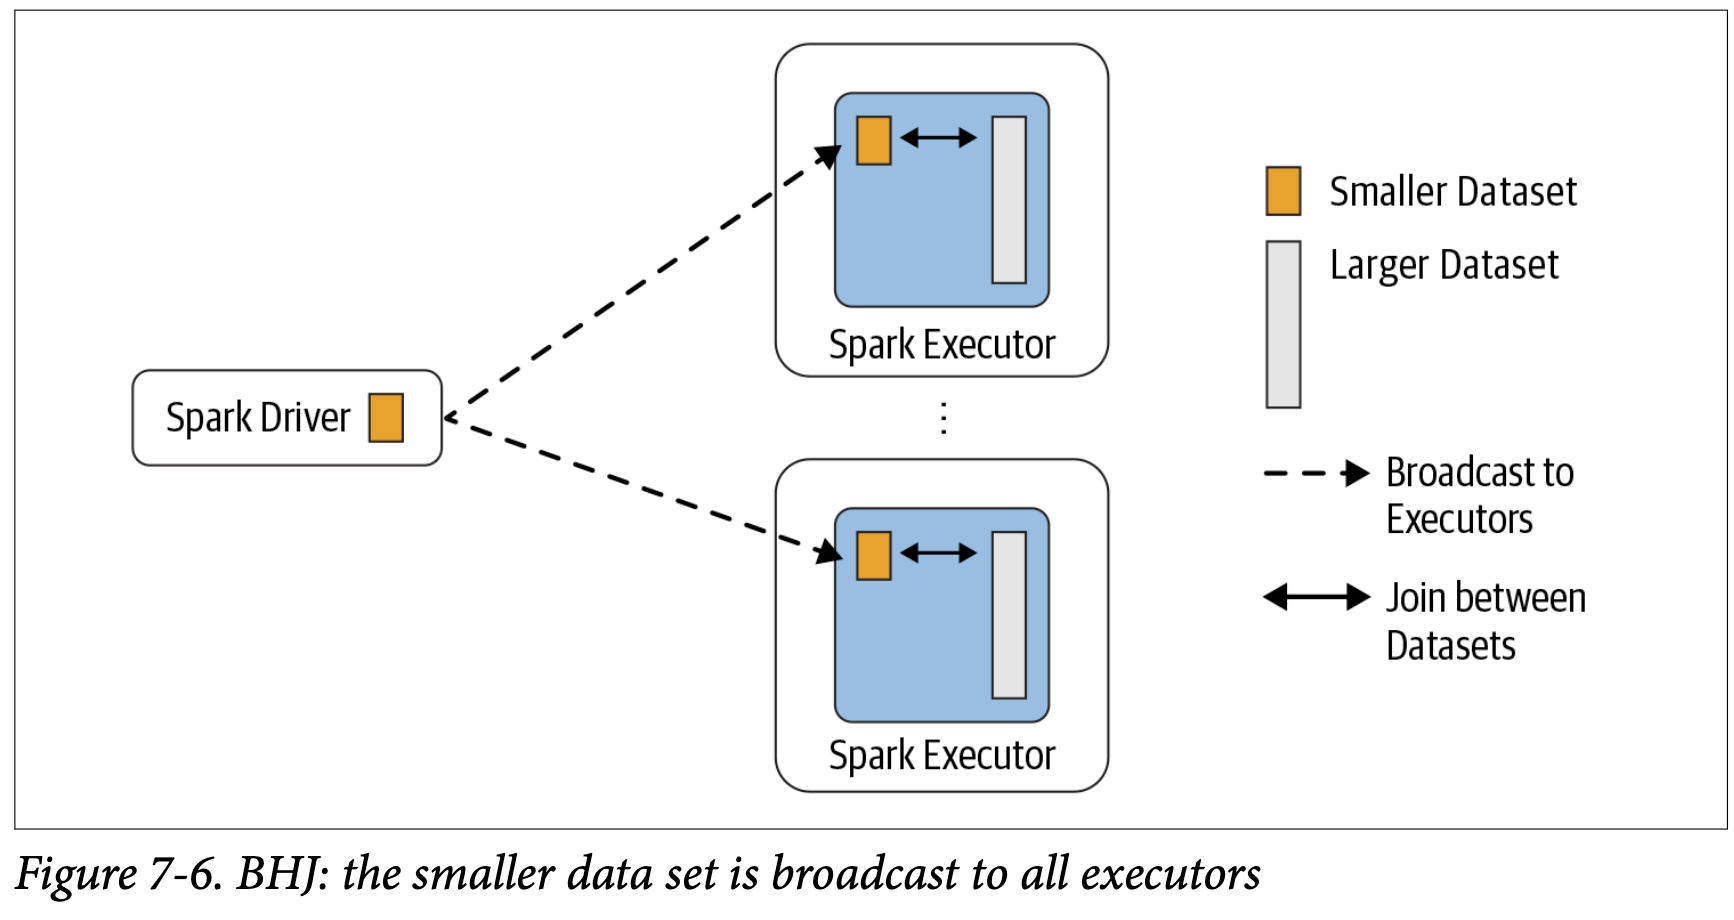

In [9]:
import findspark
findspark.init()

from pyspark.sql import SparkSession
import collections

# Initialize SparkSession
spark = SparkSession.builder \
    .appName("Broadcast_Join") \
    .getOrCreate()

24/06/18 13:14:27 WARN Utils: Your hostname, Sateeshs-MacBook-Pro.local resolves to a loopback address: 127.0.0.1; using 10.84.154.33 instead (on interface en0)
24/06/18 13:14:27 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/06/18 13:14:27 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/06/18 13:14:45 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


In [19]:
from pyspark.sql.functions import broadcast, col

In [17]:
#Disable deafult broadcast Join
spark.conf.set("spark.sql.autoBroadcastJoinThreshold", -1)

In [10]:
# Customers_data.csv file size is 5 KB
df_customer = spark.read.csv("Customers_data.csv", header=True, inferSchema=True)

In [11]:
# Orders_data.csv file size is 10 MB
df_order = spark.read.csv("Orders_data.csv", header=True, inferSchema=True)

In [12]:
df_customer.printSchema()

root
 |-- CustomerID: integer (nullable = true)
 |-- FirstName: string (nullable = true)
 |-- LastName: string (nullable = true)
 |-- Address: string (nullable = true)
 |-- City: string (nullable = true)
 |-- CountryID: integer (nullable = true)



In [13]:
df_order.printSchema()

root
 |-- OrderID: integer (nullable = true)
 |-- CustomerID: integer (nullable = true)
 |-- ProductID: integer (nullable = true)
 |-- OrderDate: date (nullable = true)
 |-- QuantityOrdered: integer (nullable = true)



In [14]:
df_customer.show(5, truncate = False)

+----------+---------+---------+-----------------------------+-----------+---------+
|CustomerID|FirstName|LastName |Address                      |City       |CountryID|
+----------+---------+---------+-----------------------------+-----------+---------+
|1         |Alejandra|Camino   |Gran Via, 1                  |Madrid     |16       |
|2         |Alexander|Feuer    |Heerstr. 22                  |Leipzig    |9        |
|3         |Ana      |Trujillo |Avda. de la Constitucion 2222|Mexico D.F.|12       |
|4         |Anabela  |Domingues|Av. Ines de Castro, 414      |Sao Paulo  |4        |
|5         |Andre    |Fonseca  |Av. Brasil, 442              |Campinas   |4        |
+----------+---------+---------+-----------------------------+-----------+---------+
only showing top 5 rows



In [15]:
df_order.show(5, truncate = False)

+-------+----------+---------+----------+---------------+
|OrderID|CustomerID|ProductID|OrderDate |QuantityOrdered|
+-------+----------+---------+----------+---------------+
|1      |1         |68       |2012-08-14|1              |
|2      |1         |22       |2012-08-14|6              |
|3      |1         |66       |2012-08-14|4              |
|4      |1         |42       |2012-08-15|6              |
|5      |1         |53       |2012-08-15|2              |
+-------+----------+---------+----------+---------------+
only showing top 5 rows



In [22]:
result_df = df_order.join(broadcast(df_customer), df_customer.CustomerID==df_order.CustomerID, how = "inner")

In [23]:
result_df.explain()

== Physical Plan ==
AdaptiveSparkPlan isFinalPlan=false
+- BroadcastHashJoin [CustomerID#47], [CustomerID#17], Inner, BuildRight, false
   :- Filter isnotnull(CustomerID#47)
   :  +- FileScan csv [OrderID#46,CustomerID#47,ProductID#48,OrderDate#49,QuantityOrdered#50] Batched: false, DataFilters: [isnotnull(CustomerID#47)], Format: CSV, Location: InMemoryFileIndex(1 paths)[file:/Users/sateeshreddypatlolla/Downloads/SparkCourse/Orders_data.csv], PartitionFilters: [], PushedFilters: [IsNotNull(CustomerID)], ReadSchema: struct<OrderID:int,CustomerID:int,ProductID:int,OrderDate:date,QuantityOrdered:int>
   +- BroadcastExchange HashedRelationBroadcastMode(List(cast(input[0, int, false] as bigint)),false), [plan_id=83]
      +- Filter isnotnull(CustomerID#17)
         +- FileScan csv [CustomerID#17,FirstName#18,LastName#19,Address#20,City#21,CountryID#22] Batched: false, DataFilters: [isnotnull(CustomerID#17)], Format: CSV, Location: InMemoryFileIndex(1 paths)[file:/Users/sateeshreddypatlolla